In [1]:
# imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import cv2

In [2]:
# Initialize the data augmentation object
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # rescale image pixel values by 255
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Let's visualize some of these augmentations. First we will load an image from the training dataset randomly, we will then apply some basic preprocessing to it and we will then show the effects of the above augmentations.

In [5]:
# select an image from the training set randomly
train_images = list(paths.list_images("train"))
sample_image = np.random.choice(train_images)

# load the image, resize it, and add a batch dimension
sample_image = plt.imread(sample_image)
sample_image = cv2.resize(sample_image, (224, 224))
sample_image = np.expand_dims(sample_image, axis=0)

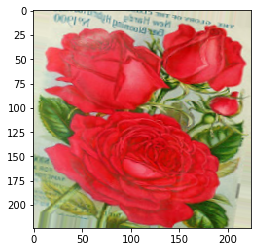

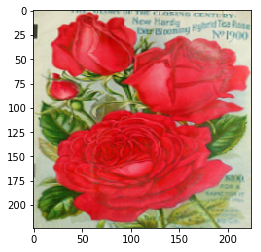

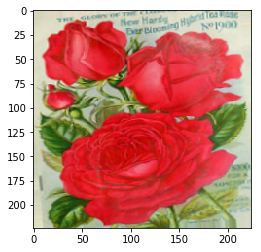

In [6]:
# construct the generator and initialize the total number of 
# images generated thus far
image_aug = img_gen.flow(sample_image, batch_size=1)
total = 0

# loop over examples from our image data augmentation generator
for image in image_aug:
    # increment our counter
    plt.imshow(np.squeeze(image, axis=0))
    plt.show()
    total += 1
     # if we have reached 10 examples, break from the loop
    if total == 3:
        break

As ML practitioners, we should be careful about maximizing the utilization of given resources. Much of the resource utilization in an ML project lies in the following areas:

- The way data is getting fed to our model
- How the model is training

Let's start with the first one. Let's investigate the time it takes to process the entire stream of training data using `ImageDataGenerator`. First, let's verify the shapes of the images and labels.

In [7]:
# construct the training data generator and verify the shapes
train_gen = img_gen.flow_from_directory("train",
            class_mode="categorical",
            target_size=(224, 224),
            color_mode="rgb",
            shuffle=True)
images, labels = next(train_gen)
images.shape, labels.shape

Found 3120 images belonging to 5 classes.


((32, 224, 224, 3), (32, 5))

Looks good! Following is the function that takes care of measuring the processing time. The function is taken from here: https://www.tensorflow.org/tutorials/load_data/images#performance. 

In [10]:
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(32*steps/duration))

In [11]:
timeit(train_gen)

....................................................................................................
1000 batches: 373.48015546798706 s
85.68059 Images/s


**Can we optimize this?**